In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈

# GPU 선택 -> '1': 두 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
actions = [
    '0',
    '1',
    '2'
]

data = np.concatenate([
    np.load('dataset/seq_0_1711072701.npy'),
    np.load('dataset/seq_1_1711072817.npy'),
    np.load('dataset/seq_2_1711072846.npy'),
], axis=0)

data.shape
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(293, 5, 100)

In [4]:
# 시퀀스의 마지막 열 제외한 모든 열 가져와 할당
# 첫 번째 행의 마지막 열은 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
# print(data[0,1,:])
print(labels.shape)
print(np.unique(labels))    # 레이블 값 출력

(293, 5, 100)
(293,)
[0. 1. 2.]


In [5]:
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(293, 3)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(263, 5, 99) (263, 3)
(30, 5, 99) (30, 3)


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=300,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, 50 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/300
1/9 [==>...........................] - ETA: 11s - loss: 8.2486 - acc: 0.6562
Epoch 1: val_acc improved from -inf to 0.93333, saving model to models\model.h5
9/9 [==============================] - 2s 59ms/step - loss: 3.2516 - acc: 0.6540 - val_loss: 0.4606 - val_acc: 0.9333 - lr: 0.0010
Epoch 2/300
1/9 [==>...........................] - ETA: 0s - loss: 0.9372 - acc: 0.7500
Epoch 2: val_acc did not improve from 0.93333
9/9 [==============================] - 0s 8ms/step - loss: 0.7121 - acc: 0.8327 - val_loss: 0.3292 - val_acc: 0.8667 - lr: 0.0010
Epoch 3/300
1/9 [==>...........................] - ETA: 0s - loss: 0.6420 - acc: 0.8125
Epoch 3: val_acc did not improve from 0.93333
9/9 [==============================] - 0s 8ms/step - loss: 0.6240 - acc: 0.8175 - val_loss: 0.3792 - val_acc: 0.8667 - lr: 0.0010
Epoch 4/300
1/9 [==>...........................] - ETA: 0s - loss: 1.5659 - acc: 0.7500
Epoch 4: val_acc did not improve from 0.93333
9/9 [==============================] -

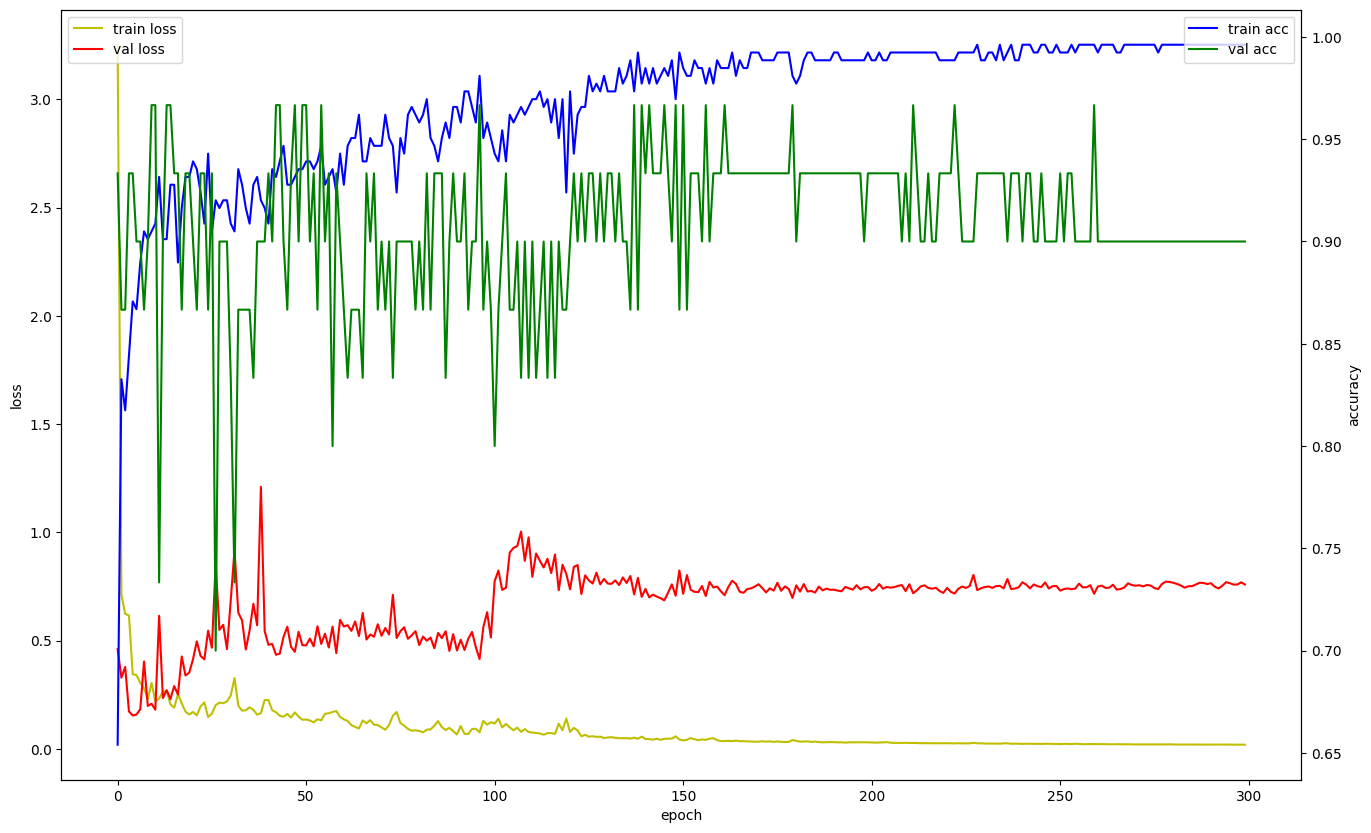

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

# 다중 레이블 혼동 행렬로 모델 평가
# [[True Negative, False Positive],
# [False Negative, True Positive]]
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

1/1 [==============================] - 0s 202ms/step


array([[[ 7,  0],
        [ 1, 22]],

       [[22,  1],
        [ 0,  7]]], dtype=int64)